In [6]:
%matplotlib inline
import warnings
## scipy gives a waring when reading wav file
warnings.filterwarnings('ignore')

import scipy as sp
import scipy.io.wavfile
import scipy.signal
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

lenght of audio 130188024
data space size 2000 by 11519 totalling 23038000


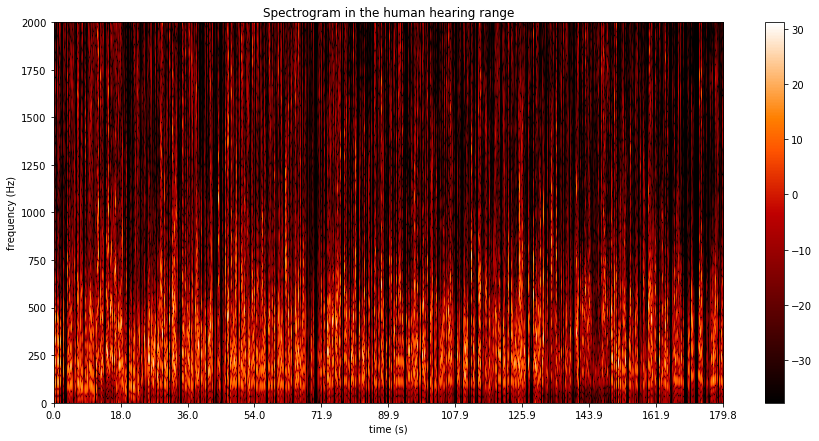

In [29]:
import importlib
from tools import tools
from matplotlib import pyplot as plt
import importlib
importlib.reload(tools)

# sample_rate, wav_data = scipy.io.wavfile.read("audio-files/kombucha.wav")
sample_rate, wav_data = sp.io.wavfile.read("audio-files/radiolab_crispr.wav")
# sample_rate, wav_data = sp.io.wavfile.read("audio-files/relief.wav")

# filtering out commercials
start_point = 130 * sample_rate

## taking just one channel
audio_data = wav_data[:, 1]
audio_data = audio_data[start_point:]

    
segment_length = int(sample_rate/32)
overlap = int(segment_length / 2)
freq_bins, time_points, spectrogram = tools.generateSpectrogram(
    audio_data, segment_length, sample_rate, overlap, 2000, 180)
specdb = tools.todB(spectrogram + 1)

# plotting
f = tools.plotSpectrogram(specdb[:,0:50], time_points[0:50])

# additional info
dbmax, dbmin = np.max(specdb), np.min(specdb)
dbrange = dbmax - dbmin
print("lenght of audio", len(audio_data))
print("data space size", specdb.shape[0], "by", specdb.shape[1], "totalling", specdb.shape[0] * specdb.shape[1], )

In [113]:
importlib.reload(tools)

limitd = 1000
num_samples = 100
# sample with the angles constrained
sample_ca = tools.sample_opt_constraint(specdb, num_samples, limitx, limity, angle_constraint=0)
sample_cd = tools.sample_opt_constraint(specdb, num_samples, limitx, limity, distance_const=1)
sample_cad = tools.sample_opt_constraint(specdb, num_samples, limitx, limity, angle_constraint=0, distance_const=1)

h_ca, b_ca = np.histogram(sample_ca, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)
h_cd, b_cd = np.histogram(sample_cd, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)
h_cad, b_cad = np.histogram(sample_cad, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)

fig = plt.figure(figsize=(15,10))
plt.plot(b_ca[1:], h_ca * h_cd)
plt.plot(b_cad[1:], h_cad)
plt.vlines([0,1], 0, np.max(np.concatenate((h_ca, h_cd, h_cad))), linestyles="dotted", colors="#797DB8")
_discard = plt.legend(["a comb b", "a=0; d=1"], bbox_to_anchor=(1.12, 1))

TypeError: sample_opt_constraint() got multiple values for argument 'distance_const'

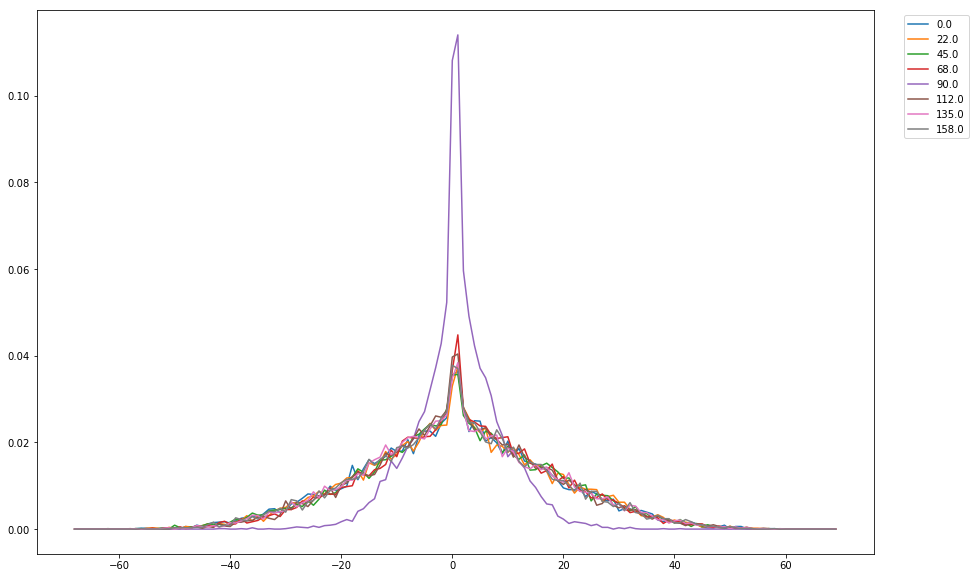

In [112]:
importlib.reload(tools)
fig = plt.figure(figsize=(15,10))

limitd = 1000
num_samples = 10000

angle_constraint_deg=np.arange(0,180,22.5)
# angle_constraint_deg=np.array([0, 45, 90, 135])
angle_constraint = angle_constraint_deg * (np.pi / 180)
distance_constraint = np.full(angle_constraint.shape, 50)

samples_ac = tools.sample_with_constraint(specdb, num_samples, limitd, angle_constraint=angle_constraint, 
                                          distance_const=distance_constraint)

for i in range(samples_ac.shape[0]):
    s = samples_ac[i]
    h, b = np.histogram(s, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)
    plt.plot(b[1:], h)            

_discard = plt.legend(np.around(angle_constraint_deg, decimals=0), bbox_to_anchor=(1.12, 1))

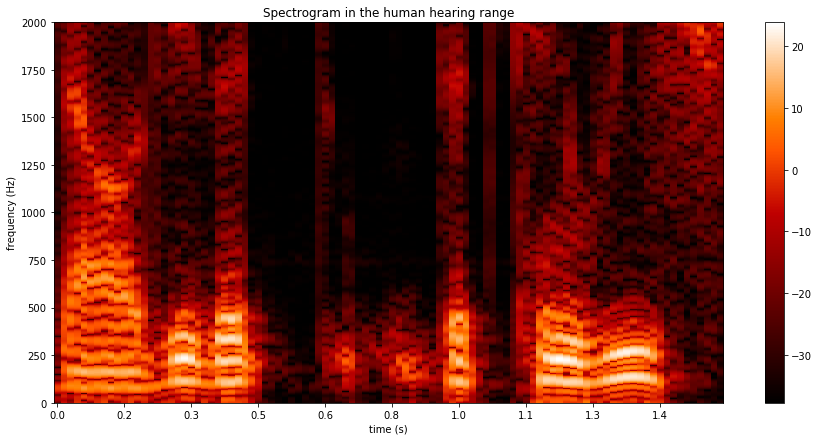

In [109]:
f = tools.plotSpectrogram(specdb[:,0:100], time_points[0:100])

In [125]:
# lets figure out using numerical methods the main edge types in the spectrogram

# the angles and jump magnitudes which we will study
tests_per_vector = 100000
angle_step = np.pi / 16
mag_step = 0.01
angles = np.arange(np.pi, step=angle_step)
jmsat = 1
jump_mag = 0.5 * specdb.shape[0] * np.power(np.arange(1, step=mag_step), 3) + jmsat
jump_mag = np.unique(np.rint(jump_mag))

## !! overriding from the above cell
angles = a
jump_mag = j

# print(jump_mag)

test_vectors = cartesian_coord(angles, jump_mag)

test_mag_bounds = np.concatenate(([jmsat], jump_mag))
test_mag_bounds = np.diff(test_mag_bounds)
test_mag_bounds = np.reshape(np.concatenate((test_mag_bounds, jump_mag)), (2, jump_mag.shape[0])).T
test_mag_bounds = np.repeat(test_mag_bounds, repeats = angles.shape[0], axis=0)

# locations which are possible starting locations (high activation)
xp, yp = np.meshgrid(np.arange(specdb.shape[0]), np.arange(specdb.shape[1]))
test_start_locations = np.stack([xp, yp], axis = 2)
test_start_locations = np.reshape(test_start_locations, (xp.shape[0]*xp.shape[1], 2))
# print(test_start_locations[0:50])

tr_buff = np.empty((test_vectors.shape[0], 2))

# for i in np.arange(500, 550):
for i in np.arange(test_vectors.shape[0]):
# i = 52
    v = test_vectors[i]
    s_pos_rint = np.random.randint(0, test_start_locations.shape[0], size=tests_per_vector)
    s_pos = test_start_locations[s_pos_rint]
    r = np.random.rand(tests_per_vector, test_vectors.shape[1])
    vr = r
    # the angle can take any value between angles of neighbouring test vectors
    b = test_mag_bounds[i]
    vr[:, 0] = (vr[:, 0] * 2 - 1) * (angle_step) + v[0]
    vr[:, 1] = b[1] - vr[:, 1] * b[0]

    coord_th = np.rint([pol2cart(th, mag) for th, mag in vr]).astype(int)
    coord_th = coord_th[:, [1,0]]
    coord = (coord_th + s_pos)
    # making sure the index is not out of bounds
    coord_cond = (coord[:,0] < specdb.shape[0]) & (coord[:,0] >= 0) & (coord[:,1] < specdb.shape[1]) & (coord[:,1] >= 0)
    s_pos_res = s_pos[coord_cond]
    coord = coord[coord_cond]
    coord = coord.T
    
    s_pos_res = s_pos_res.T
    res_diffs = specdb[coord[0], coord[1]] - specdb[s_pos_res[0], s_pos_res[1]]

    ## comparing to the distribution for the same jump size
    h,b = np.histogram(res_diffs, bins=int(np.ceil(srange*2)), range=(-srange, srange), density=True)
    h_base = hyp_dist[np.flatnonzero(jump_mag == v[1])[0]]
    
    res_dist_diff = np.sum(np.abs(h - h_base))
    
    tr_buff[i] = np.array([res_dist_diff])

    
print("Test results")
print("test location sites: ", test_start_locations.shape[0])
print("data space size: ", specdb.shape)
print("test vectors number", test_vectors.shape[0])
np.set_printoptions(precision=2, suppress=True)
test_results = np.concatenate((test_vectors, tr_buff), axis=1)
test_results[:,0] = np.round(test_results[:,0] / np.pi, 2)
# print(test_results[0:50])

Test results
test location sites:  3839000
data space size:  (1000, 3839)
test vectors number 256


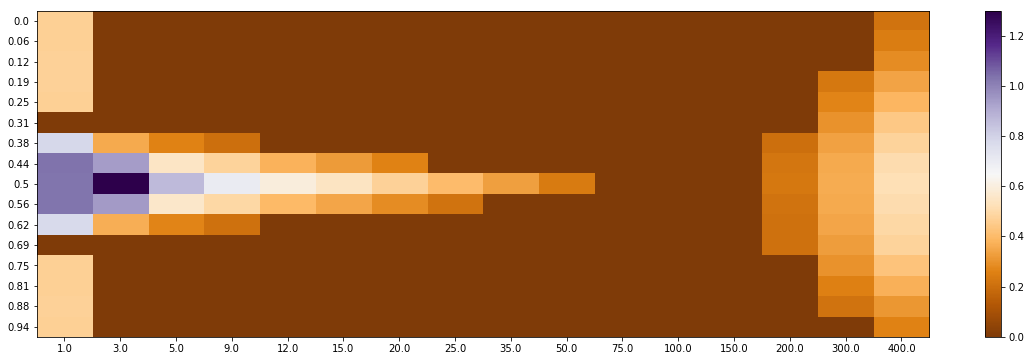

In [132]:
tr_plot = np.reshape(test_results[:,2], (jump_mag.shape[0], angles.shape[0]))
tr_plot = tr_plot

ftrp = np.zeros(tr_plot.shape)
ftrp[tr_plot>0.2] = tr_plot[tr_plot>0.2]

fig = plt.figure(figsize=(20,6))
plt.imshow(ftrp.T, aspect="auto", cmap=plt.cm.PuOr)
plt.yticks(np.arange(angles.shape[0]), np.round(angles / np.pi, 2))
xtpos = np.arange(jump_mag.shape[0], step=int(jump_mag.shape[0]/10))
plt.xticks(xtpos, np.rint(jump_mag[xtpos]))
plt.colorbar(orientation='vertical')


In [130]:
tr_plot[0:2]

array([[ 0.47,  0.47,  0.47,  0.47,  0.47,  0.06,  0.78,  1.04,  1.03,
         1.03,  0.78,  0.05,  0.47,  0.47,  0.47,  0.47],
       [ 0.09,  0.09,  0.09,  0.11,  0.13,  0.18,  0.36,  0.94,  1.3 ,
         0.94,  0.37,  0.18,  0.13,  0.1 ,  0.09,  0.09]])